In [56]:
import pytesseract
import numpy as np
import re
import csv
import cv2
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from reportlab.pdfgen import canvas
from reportlab.lib.pagesizes import letter
from reportlab.lib.units import inch
from reportlab.lib.styles import ParagraphStyle
from reportlab.platypus import Paragraph

# Image processing 

In [59]:
import cv2

# Load the image
image_path = "Fine4.jpeg"
image = cv2.imread(image_path)

# Check if the image was loaded successfully
if image is None:
    print("Error: Unable to load the image.")
else:
    print("Image loaded successfully.")


Image loaded successfully.


In [60]:
# Function to enhance image quality
def enhance_image(image):
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Ensure the grayscale image is in the correct data type (8-bit unsigned integer)
    gray = np.uint8(gray)
    
    # Apply adaptive thresholding to separate background from text
    _, thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
    
    # Invert the thresholded image
    thresholded = cv2.bitwise_not(thresholded)
    
    # Sharpen the image
    kernel = np.array([
        [-1, -1, -1],
        [-1, 12, -1],  # Increase center weight
        [-1, -1, -1]
    ])
    sharpened = cv2.filter2D(thresholded, -1, kernel)
    
    return sharpened

# Enhance the image quality
enhanced_image = enhance_image(image)


##### Denoiser 

In [61]:
import numpy as np

def denoise_image(enhanced_image):
    denoised_image = cv2.fastNlMeansDenoising(image, None, h=30, templateWindowSize=7, searchWindowSize=21)
    return denoised_image

denoised_image = denoise_image(enhanced_image)


KeyboardInterrupt: 

# Check Difference 

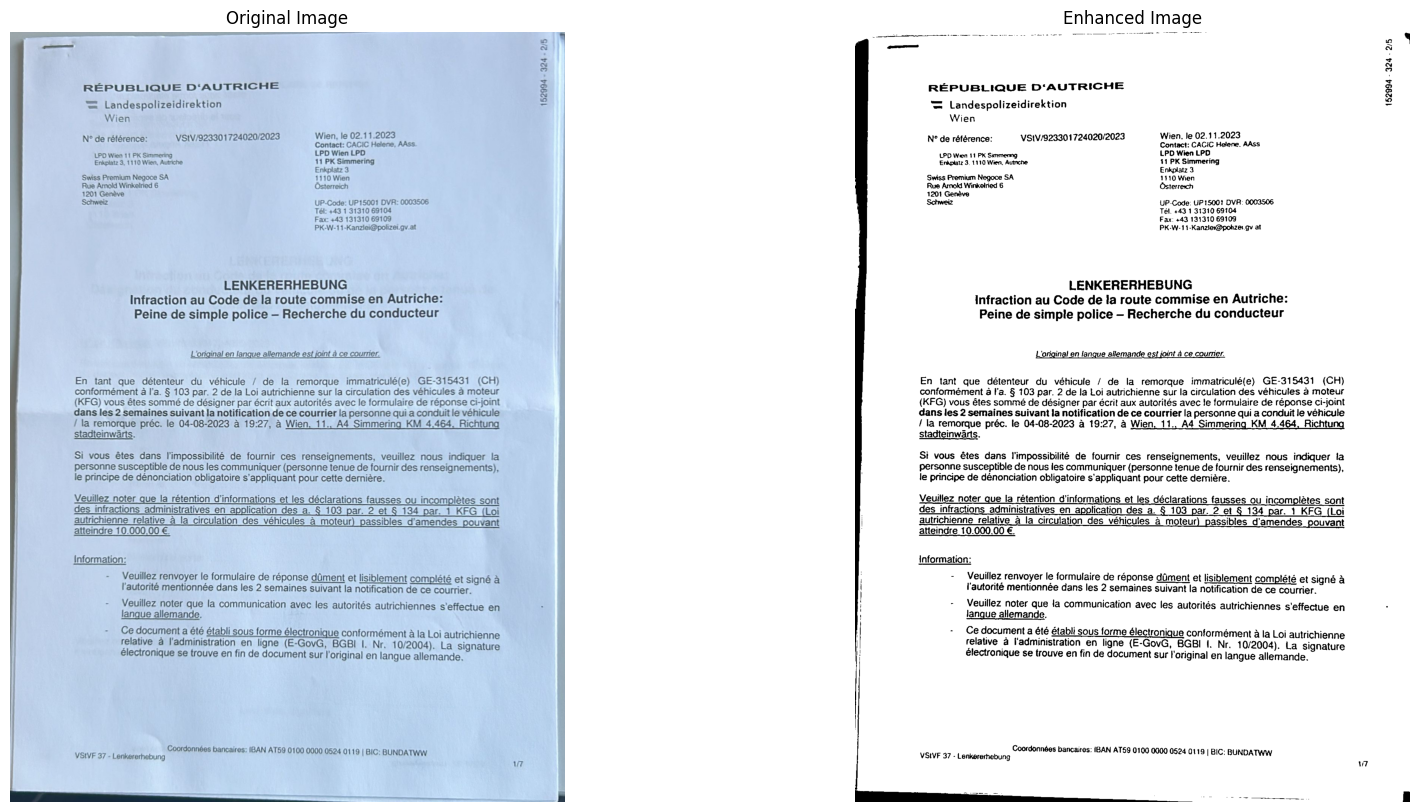

In [62]:
# Plot the original and enhanced images
plt.figure(figsize=(20, 10))

# Plot the original image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# Plot the enhanced image
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image, cmap='gray')
plt.title('Enhanced Image')
plt.axis('off')
plt.savefig('original_and_enhanced_images.png')
plt.show()

In [ ]:
# Define a filename for the image to be saved
output_filename = 'enhanced_image.png'
# Ensure the enhanced_upscaled_image numpy array is correctly formatted
# with pixel values in the range [0, 1] before saving.
# If the values are within [0, 255], remove the multiplication by 255.
enhanced_upscaled_image_to_save = (enhanced_upscaled_image * 255).astype(np.uint8) if enhanced_upscaled_image.max() <= 1.0 else enhanced_upscaled_image
# Save the image using OpenCV
cv2.imwrite(str(current_dir / output_filename), enhanced_upscaled_image_to_save)
print(f"Image saved as {output_filename} in the current directory")

# Extract Text 

### 1.Detect Language

#### Extracting relevant text only 

Detected language: fr


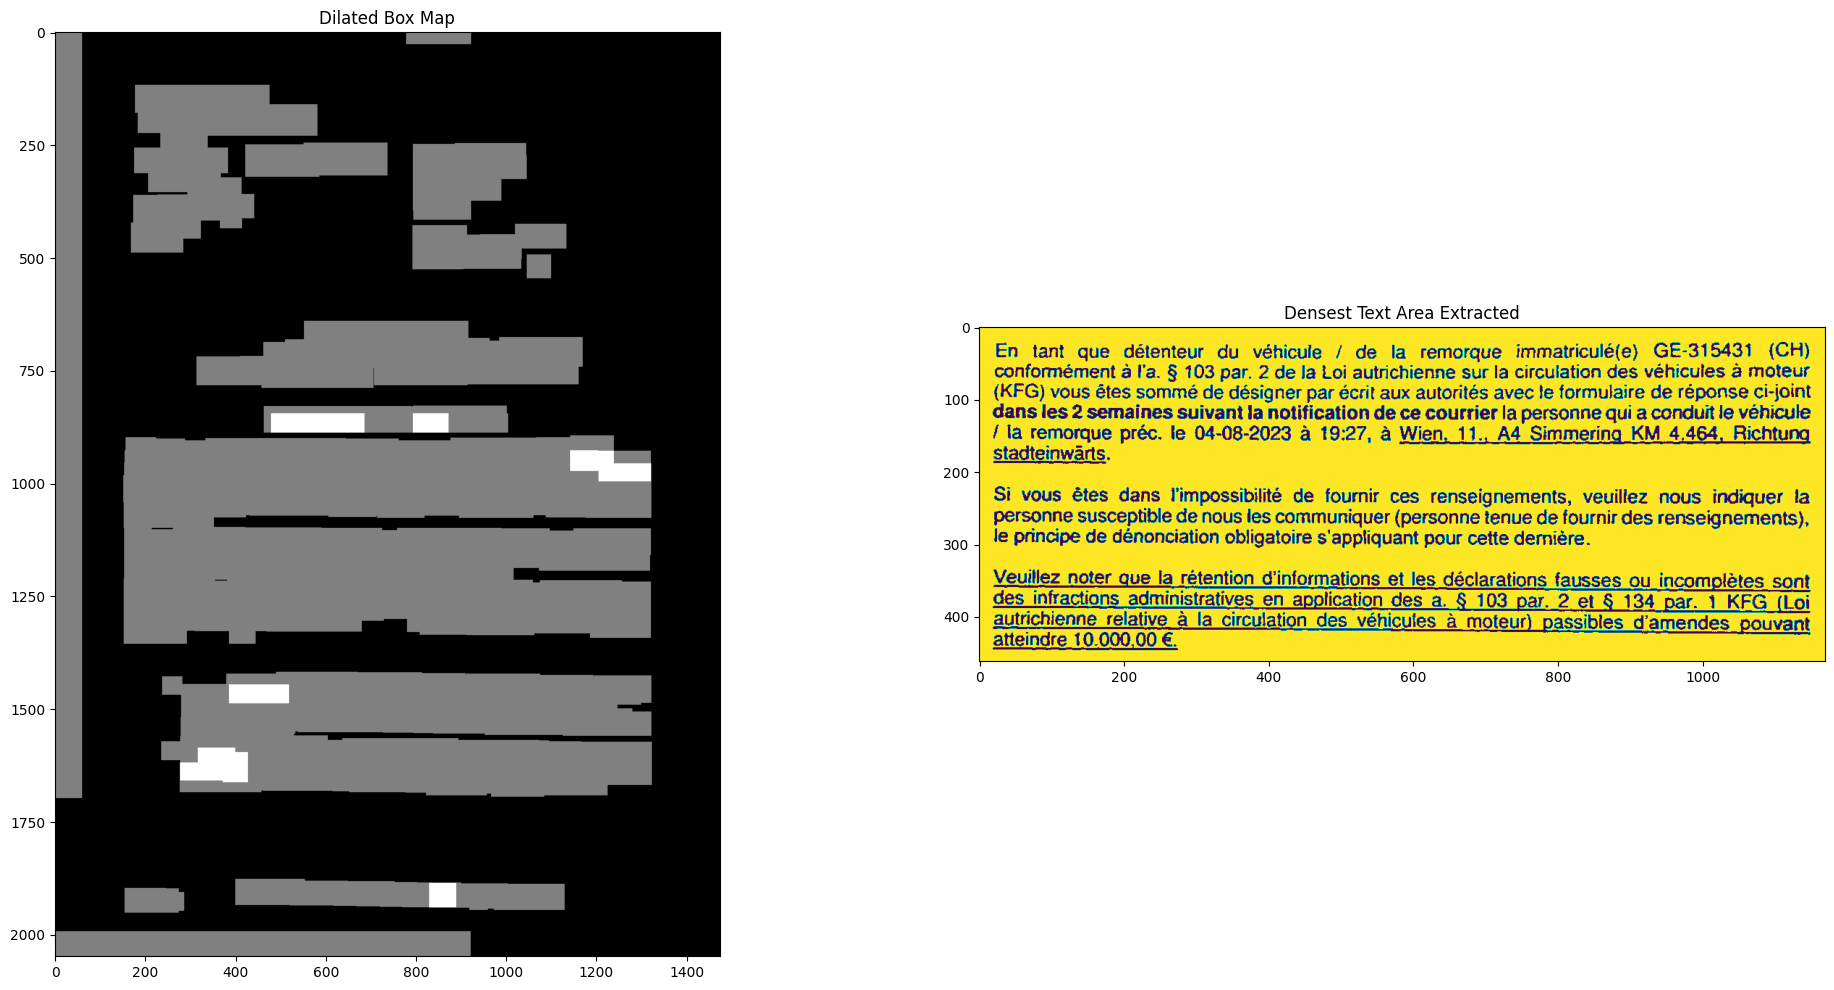

Densest text extracted:
En tant que détenteur du véhicule / de la remorque immatriculé(e) GE-31 5431 (CH)
conformément à l'a. & 103 par. 2 de la Loi autrichienne sur la circulation des véhicules à moteur
{KFG) vous êtes sommé de désigner par écrit aux autorités avec te formulaire de réponse ci-joint
dans les 2 semaines suivant la notification de ce courrier la personne qui a conduit le véhicule
Î la remorque préc. le 04-08-2023 à 19:27, à Wien, 11. A4 Simmerina KM 4,464, Richtung
stadteinwarts.

Si vous êtes dans l'impossibilité de fournir ces renseignements, veuillez nous indiquer la
personne susceptible de nous les communiquer (personne tenue de fournir des renseignements),
le principe de dénonciation obligatoire s'appliquant pour cette dernière.

Veuillez noter que la rétention d'informations et les déclarations fausses ou incomplètes sont

des infractions administratives en application des a, & 103 par. 2 et & 134 par. 1 KFG {Loi

autrichienne relative à la circulation des véhicule

In [63]:
import langdetect
from langdetect.lang_detect_exception import LangDetectException

def detect_language(image):
    try:
        if isinstance(image, np.ndarray):
            image = Image.fromarray(image)
        
        text = pytesseract.image_to_string(image)
        language = langdetect.detect_langs(text)
        # Return the most probable language
        return language[0].lang
    except LangDetectException as e:
        print("Language detection error:", e)
        return None

# Now, determine the language of the document image
language = detect_language(enhanced_image)

if language:
    print("Detected language:", language)
    # Based on detected language, set Tesseract configuration
    if language == 'fr':
        config = '--psm 4 -l fra'
    elif language == 'de':
        config = '--psm 4 -l deu'
    elif language == 'it':
        config = '--psm 4 -l ita'
    else:
        print("Unsupported language detected.")
        config = ''
        
    # If a supported language is detected, proceed with text extraction
    if config:
        def find_densest_text_area(image, config):
            if isinstance(image, np.ndarray):
                image = Image.fromarray(image)
            
            image_np = np.array(image)
            data = pytesseract.image_to_data(image, config=config, output_type=pytesseract.Output.DICT)
            box_map = np.zeros(image_np.shape[:2], dtype=np.uint8)

            for i in range(len(data['text'])):
                if int(data['conf'][i]) > 60:
                    x, y, w, h = data['left'][i], data['top'][i], data['width'][i], data['height'][i]
                    box_map[y:y+h, x:x+w] += 1

            kernel_size = 40 # Increase kernel size for more aggressive merging
            kernel = np.ones((kernel_size, kernel_size), np.uint8)
            box_map_dilated = cv2.dilate(box_map, kernel, iterations=1)

            threshold_value = np.max(box_map_dilated) * 0.4  # Lower the threshold slightly
            _, box_map_thresholded = cv2.threshold(box_map_dilated, threshold_value, 255, cv2.THRESH_BINARY)

            # Set up the figure with two subplots
            plt.figure(figsize=(24, 12))  # Set the figure size to be wide enough for two subplots
            
            # Subplot for the dilated box map
            plt.subplot(1, 2, 1)  # (1 row, 2 columns, 1st subplot)
            plt.imshow(box_map_dilated, cmap='gray')
            plt.title("Dilated Box Map")

            contours, _ = cv2.findContours(box_map_thresholded.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            if not contours:
                print("No dense text areas detected.")
                plt.show()
                return None

            img_center_x, img_center_y = image.width // 2, image.height // 2
            max_score = 0
            best_rect = None
            for contour in contours:
                x, y, w, h = cv2.boundingRect(contour)
                area = w * h
                center_x, center_y = x + w // 2, y + h // 2
                distance = np.sqrt((center_x - img_center_x)**2 + (center_y - img_center_y)**2)
                score = area / (distance + 1)  # Increased weight to area

                if score > max_score:
                    max_score = score
                    best_rect = (x, y, w, h)

            if not best_rect:
                print("No suitable area found.")
                plt.show()
                return None

            x, y, w, h = best_rect
            densest_area = image.crop((x, y, x + w, y + h))

            # Subplot for the selected densest area
            plt.subplot(1, 2, 2)  # (1 row, 2 columns, 2nd subplot)
            plt.imshow(densest_area)
            plt.title('Densest Text Area Extracted')
            plt.savefig('Relevant text and heatmap.png')
            plt.show()

            densest_text = pytesseract.image_to_string(densest_area, config=config)
            return densest_text

        # Convert upscaled numpy array back to PIL Image
        enhanced_upscaled= Image.fromarray(enhanced_image)

        # Now, find the densest text area in the upscaled image
        densest_text = find_densest_text_area(enhanced_upscaled, config)
        if densest_text:
            print("Densest text extracted:")
            print(densest_text)
        else:
            print("No text was extracted.")
    else:
        print("Language detection failed.")


### Metrics

In [40]:
from sklearn.metrics import precision_score, recall_score, f1_score

def read_text_file(file_path):
    """Reads text from a file."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def evaluate_text_samples(ground_truth_text, extracted_text):
    """Calculates precision, recall, and F1 score for text samples."""
    # Convert texts to sets of words for comparison
    ground_truth_set = set(ground_truth_text.split())
    extracted_set = set(extracted_text.split())

    # Calculate precision, recall, and F1 score
    precision = len(ground_truth_set.intersection(extracted_set)) / len(extracted_set)
    recall = len(ground_truth_set.intersection(extracted_set)) / len(ground_truth_set)
    f1 = 2 * (precision * recall) / (precision + recall)

    return precision, recall, f1

# Define paths to ground truth and extracted text files
ground_truth_path = "CorrectText.txt"
extracted_text_path = "ExtractedText.txt"

# Read text from files
ground_truth_text = read_text_file(ground_truth_path)
extracted_text = read_text_file(extracted_text_path)

# Calculate precision, recall, and F1 score
precision, recall, f1 = evaluate_text_samples(ground_truth_text, extracted_text)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Precision: 0.7348066298342542
Recall: 0.9047619047619048
F1 Score: 0.8109756097560975


# Translate from any language to English 

In [41]:
from googletrans import Translator

def translate_to_english(densest_text):
    translator = Translator()

    # Detect language
    detected_lang = translator.detect(densest_text).lang

    # Translate to English if necessary
    if detected_lang != 'en':
        translated_text = translator.translate(densest_text, dest='en').text
    else:
        translated_text = densest_text

    return translated_text

translated_text = translate_to_english(densest_text)
print("Translated Text:", translated_text)

Translated Text: Order fine n ° 123491806 001 0

Dear,
The driver of the following vehicle has contravened the federal federal prescription (s) on the
traffic.

303.2.b exceed, outside the localities or on a semi-autoroute, the speed CHF 100.00
maximum reported, after deduction of the inherent margin of error
devices and measurements, set by OFROU from 6 to 10 km/h
Total amount CHF 100.00
Vehicle: GE 305362/Auto
Location: 1225 Oak-Bourg RTE.de Malagnou 251, direction Route Blanche;

Date/hour: July 1, 2023 at 14:14;
Established by: Matricle - P02048

Authorized speed: 60 km/h
Speed measured: 75 km/h
Deduction of the safety margin: -5 km/h

Overcoming the authorized speed: 10 km/h

Confo environment, 6 Lao, a period of 30 days is granted to you to pay the fine
mentioned above by means of the attached QR-Factor.In the event of partial payment or
: non-payment within 30 days, the ordinary procedure will be initiated.This one
is not held by the amounts appearing in the list of fines of ord

# Extreact Features (NLP)

In [42]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering, pipeline

# Load a more powerful pre-trained model and tokenizer
model_name = "bert-large-uncased-whole-word-masking-finetuned-squad"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForQuestionAnswering.from_pretrained(model_name)

# Set up the question-answering pipeline
qa_pipeline = pipeline("question-answering", model=model, tokenizer=tokenizer)

# Assuming 'translated_text' is the context obtained from previous text processing steps
questions = [
    "What is the plate number of the car?",
    "When did the infraction happen?",
    "What was the infraction?"
]

# Get answers from the model using the translated text as context
answers = {question: qa_pipeline({"question": question, "context": translated_text})['answer'] for question in questions}

# Print the answers
for question, answer in answers.items():
    print(f"Question: {question}\nAnswer: {answer}\n")

Some weights of the model checkpoint at bert-large-uncased-whole-word-masking-finetuned-squad were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Question: What is the plate number of the car?
Answer: GE 305362

Question: When did the infraction happen?
Answer: July 1, 2023

Question: What was the infraction?
Answer: contravened the federal federal prescription (s)



# Fine Estimation

In [43]:
import pandas as pd
import dateparser

# Function to convert date to standard format
def convert_date_to_standard_format(date_str):
    try:
        settings = {'DATE_ORDER': 'DMY', 'PREFER_DAY_OF_MONTH': 'first'}
        
        parsed_date = dateparser.parse(date_str, settings=settings)
        formatted_date = parsed_date.strftime('%d/%m/%Y')
        return formatted_date
    except ValueError:
        return None

# Function to match extracted information with CSV file
def match_with_csv(answers):
    plate_number = answers["What is the plate number of the car?"]
    offense_date = answers["When did the infraction happen?"]
    infraction = answers["What was the infraction?"]
    
    standard_offense_date = convert_date_to_standard_format(offense_date)
    
    if standard_offense_date is None:
        return pd.DataFrame() 
    
    file_path = ("Cars_sales_data_2023.xlsx")
    df = pd.read_excel(file_path)
    
    df['Pick Up DateTime'] = pd.to_datetime(df['Pick up date'], format='%d/%m/%Y')
    df['Drop Off DateTime'] = pd.to_datetime(df['Drop off date'], format='%d/%m/%Y')
    
    matching_rows = df[(df['Plate Number'] == plate_number) &
                       (df['Pick Up DateTime'] <= standard_offense_date) &
                       (df['Drop Off DateTime'] >= standard_offense_date)]
    
    return matching_rows

# Match extracted information with the CSV file
matching_rows = match_with_csv(answers)

# Extract client name if a match is found
if not matching_rows.empty:
    client_name = matching_rows.iloc[0]['Client name']
    print("Nom du client trouvé :", client_name)
    
else:
    print("Aucun enregistrement correspondant trouvé pour les informations extraites.")


Aucun enregistrement correspondant trouvé pour les informations extraites.


In [45]:
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from FineEstimator import estimate_fine, estimate_parking_fine

# Load a pre-trained model and tokenizer for sequence classification
model_name = "textattack/bert-base-uncased-imdb"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Set up the text classification pipeline
classification_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# Translate the text if needed and obtain the translated_text variable

# Assuming 'translated_text' is the context obtained from previous text processing steps

# Run sentiment analysis to identify if the document contains information about speeding or parking
sentiment_result = classification_pipeline(translated_text)

# Check if the sentiment result is empty or not
if sentiment_result:
    # Check if the sentiment indicates a violation related to speeding or parking
    violation_type = None
    if sentiment_result[0]['label'] == 'LABEL_1':
        violation_type = 'speeding'
    elif sentiment_result[0]['label'] == 'LABEL_0':
        violation_type = 'parking'

    # Define regular expressions to match speed-related phrases
    measured_speed_pattern = re.compile(r'Speed measured: (\d+)\s+km/h')
    allowed_speed_pattern = re.compile(r'Authorized speed: (\d+)\s+km/h')

    # Extract relevant information based on the detected violation type
    if violation_type == 'speeding':
        # Search for measured speed and allowed speed in the translated text using regular expressions
        measured_speed_match = measured_speed_pattern.search(translated_text)
        allowed_speed_match = allowed_speed_pattern.search(translated_text)

        # Extract measured speed and allowed speed from the matches
        measured_speed = int(measured_speed_match.group(1)) if measured_speed_match else None
        allowed_speed = int(allowed_speed_match.group(1)) if allowed_speed_match else None

        # Estimate speeding fine using the FineEstimator.py module
        if measured_speed is not None and allowed_speed is not None:
            speeding_fine = estimate_fine(allowed_speed, measured_speed)
            # Notify the driver about the speeding violation and the estimated fine
            print(f"You were caught speeding at {measured_speed} km/h in a {allowed_speed} km/h zone.")
            print(f"Estimated fine for speeding: {speeding_fine}")
        else:
            print("Speeding information not found in the translated text.")

    elif violation_type == 'parking':
        # Check for parking violation in the translated text
        if "unlawful parking" in translated_text:
            parking_violation_type = "unlawful parking"
        elif "parking outside of a designated zone" in translated_text:
            parking_violation_type = "parking outside of a designated zone"

        # Estimate parking fine using the FineEstimator.py module
        parking_fine = estimate_parking_fine(parking_violation_type)
        # Notify the driver about the parking violation and the estimated fine
        print(f"You have committed a {parking_violation_type} violation.")
        print(f"Estimated fine for parking violation: {parking_fine} CHF")
else:
    print("Sentiment analysis did not detect any violations in the document.")


You were caught speeding at 75 km/h in a 60 km/h zone.
Estimated fine for speeding: No fine information available for this range
